<a href="https://colab.research.google.com/github/Aniketkoppaka/ML-PROJECTS/blob/main/fresh_rotten_fruits_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⭐ AI-Powered Fruit Freshness Classifier  
### Using Transfer Learning (MobileNetV2)

---

## 📌 Project Overview  
This project aims to build a **lightweight, fast, and accurate image classifier** that determines whether fruits (strawberries, peaches, pomegranates) are **fresh or rotten**.

We use:

- A clean, consistent dataset  
- Transfer learning with **MobileNetV2**  
- Light data augmentation  
- A small custom neural network head  
- Real-image testing for verification  

This gives us:

✔ High accuracy  
✔ Low computation cost  
✔ Strong real-world usability  




# ⭐ Notebook Structure & Explanation of Each Code Cell





---

## 🧩 1. Mount Google Drive & Import Dependencies  
This cell mounts Google Drive so the dataset can be accessed and imports all required libraries.  




In [20]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 🧩 2. Set Dataset Path & Image Configuration  
In this cell, we define:

- The path to the dataset stored in Google Drive  
- The image size (`256×256`)  
- The batch size used for training  



In [21]:
DATASET_PATH = "/content/drive/MyDrive/fruits-dataset"

IMG_SIZE = 256
BATCH_SIZE = 32

## 🧩 3. Build Data Generators with Light Augmentation  
We use **ImageDataGenerator** to:

- Normalize pixel values  
- Apply light augmentations (rotation, zoom, brightness, flipping)  
- Split data into an **80/20 train-validation** ratio  

We create two generators:

- `train_gen` → feeds training images in batches  
- `val_gen` → feeds validation images  



In [22]:
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

Found 1325 images belonging to 2 classes.
Found 330 images belonging to 2 classes.


## 🧩 4. Build the Transfer Learning Model  
We load **MobileNetV2** with:

- `include_top=False` (removes original classifier)  
- Pretrained ImageNet weights  
- Base layers frozen (`trainable=False`)  

Then we add:

- GlobalAveragePooling2D  
- Dense(128) with ReLU activation  
- Dropout(0.3) to reduce overfitting  
- Final Dense layer for classification  



In [23]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False   # Stage 1: freeze

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)        # NEW small dense layer
x = Dropout(0.3)(x)
preds = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=preds)

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/tmp/ipython-input-2593618404.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 🧩 5. Train the Model (Frozen Base)  
In this stage:

- Only the custom top layers train  
- MobileNetV2 feature extractor remains frozen  
- Training is stable and fast  
- Works well because our dataset is clean and uniform  



In [24]:
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.7219 - loss: 0.5338 - val_accuracy: 0.9242 - val_loss: 0.2410
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.8962 - loss: 0.2511 - val_accuracy: 0.8667 - val_loss: 0.3032
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.9251 - loss: 0.2113 - val_accuracy: 0.9424 - val_loss: 0.1677
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.9450 - loss: 0.1554 - val_accuracy: 0.9152 - val_loss: 0.2033
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.9516 - loss: 0.1445 - val_accuracy: 0.9182 - val_loss: 0.1971
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.9605 - loss: 0.1164 - val_accuracy: 0.9576 - val_loss: 0.1537
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.9481 - loss: 0.1283 - val_accuracy: 0.9455 - val_loss: 0.1644
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.9641 - loss: 0.1165 - val_accuracy: 0.9515 - v

## 🧩 6. Plot Training & Validation Accuracy and Loss  
This cell visualizes:

- Training vs validation accuracy  
- Training vs validation loss  




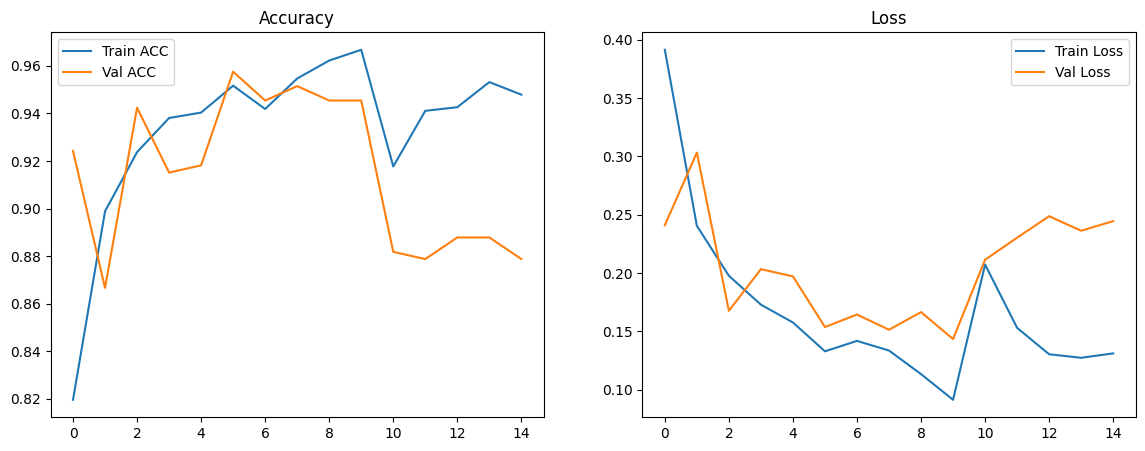

In [26]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history1.history["accuracy"] + history2.history["accuracy"], label="Train ACC")
plt.plot(history1.history["val_accuracy"] + history2.history["val_accuracy"], label="Val ACC")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history1.history["loss"] + history2.history["loss"], label="Train Loss")
plt.plot(history1.history["val_loss"] + history2.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()

## 🧩 7. Predict on Custom Test Images  
This final cell:

- Loads external images  
- Displays them with matplotlib  
- Sends them to the trained model  
- Prints predicted label and confidence score  

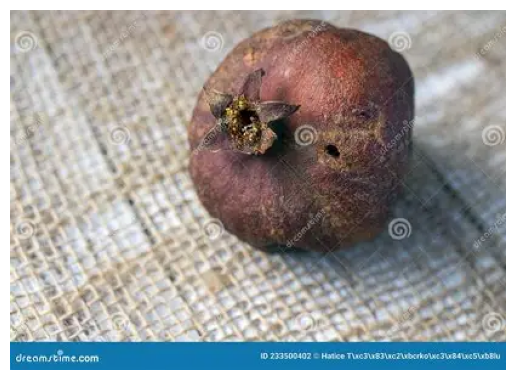

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Prediction: rotten
Confidence: 98.21%


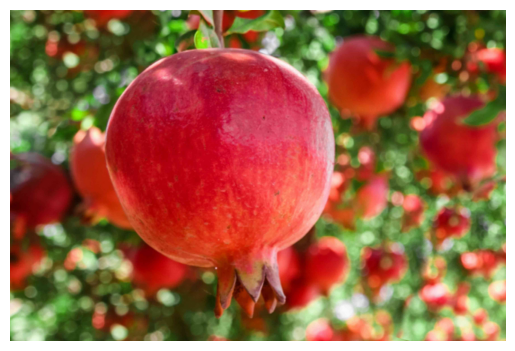

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Prediction: fresh
Confidence: 99.95%


In [35]:
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt

labels = list(train_gen.class_indices.keys())

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0]
    class_idx = np.argmax(prediction)

    print("Prediction:", labels[class_idx])
    print(f"Confidence: {prediction[class_idx]*100:.2f}%")

img_paths = [
    "/content/RottenPom.webp",
    "/content/FreshPom.jpg"
]

for img_path in img_paths:
  img_display = Image.open(img_path)
  plt.imshow(img_display)
  plt.axis('off')
  plt.show()

  predict_image(img_path)

# 🎉 Final Result  
We now have a:

- Lightweight  
- Efficient  
- hIghly Accurate  

**Fresh vs Rotten Fruit Classifier** built using transfer learning.

